<a href="https://colab.research.google.com/github/yeonheuiyeon/Machine-Learning-Practice/blob/master/20181237_%EB%A0%88%EC%8A%A86.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall torch torchvision -y
!pip install torch==1.4.0 torchvision==0.5.0

Uninstalling torch-1.4.0:
  Successfully uninstalled torch-1.4.0
Uninstalling torchvision-0.5.0:
  Successfully uninstalled torchvision-0.5.0
  Using cached https://files.pythonhosted.org/packages/24/19/4804aea17cd136f1705a5e98a00618cb8f6ccc375ad8bfa437408e09d058/torch-1.4.0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/7e/90/6141bf41f5655c78e24f40f710fdd4f8a8aff6c8b7c6f0328240f649bdbe/torchvision-0.5.0-cp36-cp36m-manylinux1_x86_64.whl


In [41]:
from google.colab import drive
drive.mount("/content/gdrive")
#drive.mount("/content/gdrive", force_remount=True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# 로스만 데이터 셋
로스만 데이터 세트는 유럽에 3,000개의 약국을 가지고 있고 몇 주 안에 얼마나 많은 제품을 팔지 예측하려고 한다. 흥미로운 점 중 하나는 이를 위한 테스트 세트가 훈련 세트보다 더 최근의 기간이라는 점이다. 예측을 진행할 때 이미 데이터 셋 안에 있는 것을 예측하는 것은 의미가 없다. 미래의 것을 예측할 수 있어야 한다.

이것의 또 다른 흥미로운 점은 그들이 제공한 평가 지표는 근 평균 제곱 퍼센트 오류라는 것이다.

RMSPE는 단지 우리가 실제 마이너스 예측을 실제값으로 나눈 것을 제외하고, 일반적인 루트 평균 제곱 오차일 뿐이기 때문에, 다시 말해서 우리가 근본 평균 제곱을 취하는 것은 "백분율" 오류인 것이다.

In [0]:
%reload_ext autoreload
%autoreload 2
from fastai.tabular import *

In [0]:
from fastai.basics import *

In [0]:
PATH=Path('/content/gdrive/My Drive/Colab Notebooks/rossmann')
table_names = ['train', 'store', 'store_states', 'state_names', 'googletrend', 'weather', 'test']
tables = [pd.read_csv(PATH/f'{fname}.csv', low_memory=False) for fname in table_names]
train, store, store_states, state_names, googletrend, weather, test = tables
len(train),len(test)

(1017209, 41088)

In [0]:

train.StateHoliday = train.StateHoliday!='0'
test.StateHoliday = test.StateHoliday!='0'

In [0]:

def join_df(left, right, left_on, right_on=None, suffix='_y'):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, 
                      suffixes=("", suffix))

In [0]:
weather = join_df(weather, state_names, "file", "StateName")

In [0]:
googletrend['Date'] = googletrend.week.str.split(' - ', expand=True)[0]
googletrend['State'] = googletrend.file.str.split('_', expand=True)[2]
googletrend.loc[googletrend.State=='NI', "State"] = 'HB,NI'

In [0]:
def add_datepart(df, fldname, drop=True, time=False):
    "Helper function that adds columns relevant to a date."
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [0]:
add_datepart(weather, "Date", drop=False)
add_datepart(googletrend, "Date", drop=False)
add_datepart(train, "Date", drop=False)
add_datepart(test, "Date", drop=False)

In [0]:
trend_de = googletrend[googletrend.file == 'Rossmann_DE']

In [0]:
store = join_df(store, store_states, "Store")
len(store[store.State.isnull()])

0

In [0]:
joined = join_df(train, store, "Store")
joined_test = join_df(test, store, "Store")
len(joined[joined.StoreType.isnull()]),len(joined_test[joined_test.StoreType.isnull()])

(0, 0)

In [0]:
joined = join_df(joined, googletrend, ["State","Year", "Week"])
joined_test = join_df(joined_test, googletrend, ["State","Year", "Week"])
len(joined[joined.trend.isnull()]),len(joined_test[joined_test.trend.isnull()])

(0, 0)

In [0]:

joined = joined.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
joined_test = joined_test.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
len(joined[joined.trend_DE.isnull()]),len(joined_test[joined_test.trend_DE.isnull()])

(0, 0)

In [0]:

joined = join_df(joined, weather, ["State","Date"])
joined_test = join_df(joined_test, weather, ["State","Date"])
len(joined[joined.Mean_TemperatureC.isnull()]),len(joined_test[joined_test.Mean_TemperatureC.isnull()])

(0, 0)

In [0]:
for df in (joined, joined_test):
    for c in df.columns:
        if c.endswith('_y'):
            if c in df.columns: df.drop(c, inplace=True, axis=1)

In [0]:
for df in (joined,joined_test):
    df['CompetitionOpenSinceYear'] = df.CompetitionOpenSinceYear.fillna(1900).astype(np.int32)
    df['CompetitionOpenSinceMonth'] = df.CompetitionOpenSinceMonth.fillna(1).astype(np.int32)
    df['Promo2SinceYear'] = df.Promo2SinceYear.fillna(1900).astype(np.int32)
    df['Promo2SinceWeek'] = df.Promo2SinceWeek.fillna(1).astype(np.int32)

In [0]:

for df in (joined,joined_test):
    df["CompetitionOpenSince"] = pd.to_datetime(dict(year=df.CompetitionOpenSinceYear, 
                                                     month=df.CompetitionOpenSinceMonth, day=15))
    df["CompetitionDaysOpen"] = df.Date.subtract(df.CompetitionOpenSince).dt.days

In [0]:
for df in (joined,joined_test):
    df.loc[df.CompetitionDaysOpen<0, "CompetitionDaysOpen"] = 0
    df.loc[df.CompetitionOpenSinceYear<1990, "CompetitionDaysOpen"] = 0

In [0]:

for df in (joined,joined_test):
    df["CompetitionMonthsOpen"] = df["CompetitionDaysOpen"]//30
    df.loc[df.CompetitionMonthsOpen>24, "CompetitionMonthsOpen"] = 24
joined.CompetitionMonthsOpen.unique()

array([24,  3, 19,  9,  0, 16, 17,  7, 15, 22, 11, 13,  2, 23, 12,  4, 10,  1, 14, 20,  8, 18,  6, 21,  5])

In [0]:
! pip install isoweek

In [0]:
from isoweek import Week
for df in (joined,joined_test):
    df["Promo2Since"] = pd.to_datetime(df.apply(lambda x: Week(
        x.Promo2SinceYear, x.Promo2SinceWeek).monday(), axis=1))
    df["Promo2Days"] = df.Date.subtract(df["Promo2Since"]).dt.days

In [0]:
for df in (joined,joined_test):
    df.loc[df.Promo2Days<0, "Promo2Days"] = 0
    df.loc[df.Promo2SinceYear<1990, "Promo2Days"] = 0
    df["Promo2Weeks"] = df["Promo2Days"]//7
    df.loc[df.Promo2Weeks<0, "Promo2Weeks"] = 0
    df.loc[df.Promo2Weeks>25, "Promo2Weeks"] = 25
    df.Promo2Weeks.unique()

In [0]:
joined.to_pickle(PATH/'joined')
joined_test.to_pickle(PATH/'joined_test')

In [0]:

def get_elapsed(fld, pre):
    day1 = np.timedelta64(1, 'D')
    last_date = np.datetime64()
    last_store = 0
    res = []

    for s,v,d in zip(df.Store.values,df[fld].values, df.Date.values):
        if s != last_store:
            last_date = np.datetime64()
            last_store = s
        if v: last_date = d
        res.append(((d-last_date).astype('timedelta64[D]') / day1))
    df[pre+fld] = res

In [0]:

columns = ["Date", "Store", "Promo", "StateHoliday", "SchoolHoliday"]

In [0]:
df = train[columns].append(test[columns])

In [0]:
fld = 'SchoolHoliday'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

In [0]:
fld = 'StateHoliday'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

In [0]:
fld = 'Promo'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

In [0]:
df = df.set_index("Date")

In [0]:
columns = ['SchoolHoliday', 'StateHoliday', 'Promo']

In [0]:

for o in ['Before', 'After']:
    for p in columns:
        a = o+p
        df[a] = df[a].fillna(0).astype(int)

In [0]:
bwd = df[['Store']+columns].sort_index().groupby("Store").rolling(7, min_periods=1).sum()

In [0]:
fwd = df[['Store']+columns].sort_index(ascending=False).groupby("Store").rolling(7, min_periods=1).sum()

In [0]:
bwd.drop('Store',1,inplace=True)
bwd.reset_index(inplace=True)

In [0]:
fwd.drop('Store',1,inplace=True)
fwd.reset_index(inplace=True)
df.reset_index(inplace=True)
df = df.merge(bwd, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
df = df.merge(fwd, 'left', ['Date', 'Store'], suffixes=['', '_fw'])
df.drop(columns,1,inplace=True)

In [0]:
df.to_pickle(PATH/'df')

df["Date"] = pd.to_datetime(df.Date)
joined = pd.read_pickle(PATH/'joined')
joined_test = pd.read_pickle(PATH/f'joined_test')
joined = join_df(joined, df, ['Store', 'Date'])
joined_test = join_df(joined_test, df, ['Store', 'Date'])

In [0]:
joined = joined[joined.Sales!=0]

In [0]:

joined.reset_index(inplace=True)
joined_test.reset_index(inplace=True)

In [0]:
joined.to_pickle(PATH/'train_clean')
joined_test.to_pickle(PATH/'test_clean')

# Rossmann Data preparation

In [0]:
path = Path('/content/gdrive/My Drive/Colab Notebooks/rossmann')
train_df = pd.read_pickle(path/'train_clean')

데이터는 그 가게나 그 가게가 대표하는 사람들에 대한 정보를 가지고 있을 것이다. 데이터는는 메타데이터를 가지고 있고, 비슷한 시간이나 다른 시간에 측정된 다른 것들의 순서를 가지고 있다. 그래서 대부분의 경우,  실제보다 더 실제적인 데이터 세트에 대한 경쟁에 관한 최신의 결과가 반복적인 신경망을 사용하지 않는 경향이 있다는 것을 실제로 발견된다. 대신, 그들은 타임피스를 가져가는 경향이 있는데, 이 경우에는 데이터로 주어진 날짜였고, 메타데이터를 추가한다.

In [0]:
train_df.head().T

,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
...,...,...,...,...,...
StateHoliday_bw,0,0,0,0,0
Promo_bw,5,5,5,5,5
SchoolHoliday_fw,7,1,5,1,1
StateHoliday_fw,0,0,0,0,0


In [0]:
n = len(train_df); n

844338

## Experimenting with a sample

1. 사전과정
 변환은 데이터 세트에서 어떤 것이 포착될 때마다 실행되는 코드 조각이기 때문에 오늘날 우리가 알게 될 데이터 확대에 정말 좋은 것으로, 샘플링될 때마다 다른 랜덤 값을 얻을 수 있다는 것이다. 전처리는 변형과 같지만, 조금 다른 점이 있는데, 그것은 어떤 훈련을 하기 전에 한 번 실행한다는 것이다. 가장 중요한 것은 train 세트에서 한 번 실행되고 생성된 모든 종류의 상태 또는 메타데이터는 검증 및 테스트 세트와 공유된다는 것이다.

예 )  우리가 이미지 인식을 하고 모든 다른 애완동물 품종들을 대상으로 일련의 수업을 했을 때, 그것들은 숫자로 바뀌었다. 우리를 위해 실제로 그렇게 하고 있는 것은 백그라운드에서 만들어지고 있는 전처리기. 따라서 train 세트의 클래스가 유효성 검사를 위한 클래스 및 테스트 세트의 클래스와 동일해야 한다.  예를 들어, 재생할 데이터의 작은 부분 집합을 만드는 경우 이것은 새로운 데이터 세트로 시작할 때 정말 좋은 생각이다.

나는 방금 무작위로 2,000개의 ID를잡았다. 그리고 나서 나는 TRAIN 세트와 TEST 세트를 잡으려고 한다. 2,000개의 ID 중 절반과 절반은 다섯 개의 기둥을 잡으려고 한다. 
보시다시피, 그 중 하나는 promo interval 이라고 불리며, 이 끈들이 있고, 때로는 없어지기도 한다. 판다에서 없는 값은 NaN이다.

In [0]:
idx = np.random.permutation(range(n))[:2000]
idx.sort()
small_train_df = train_df.iloc[idx[:1000]]
small_test_df = train_df.iloc[idx[1000:]]
small_cont_vars = ['CompetitionDistance', 'Mean_Humidity']
small_cat_vars =  ['Store', 'DayOfWeek', 'PromoInterval']
small_train_df = small_train_df[small_cat_vars + small_cont_vars + ['Sales']]
small_test_df = small_test_df[small_cat_vars + small_cont_vars + ['Sales']]

In [0]:
small_train_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
749,751,5,NaN,650.0,61,4844
776,778,5,"Jan,Apr,Jul,Oct",340.0,50,7341
1275,163,4,NaN,1480.0,55,6122
1335,223,4,"Jan,Apr,Jul,Oct",2920.0,58,6830
1670,559,4,"Feb,May,Aug,Nov",3910.0,51,7387


In [0]:
small_test_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
408267,904,2,"Jan,Apr,Jul,Oct",570.0,70,7538
408450,1087,2,NaN,2210.0,75,8157
408627,149,1,"Jan,Apr,Jul,Oct",2610.0,69,9605
408662,184,1,NaN,3560.0,64,10396
409308,830,1,"Jan,Apr,Jul,Oct",6320.0,70,11146


In [0]:
categorify = Categorify(small_cat_vars, small_cont_vars)
categorify(small_train_df)
categorify(small_test_df, test=True)

분류는 기본적으로 이미지 인식에 대해 .classes가 종속 변수에 대해 하는 것과 같은 역할을 한다. 이 끈들을 가지고, 가능한 모든 고유한 가치들을 찾아내고, 목록을 만들고, 그 줄을 숫자로 바꾸는 겁니다. 그래서 만약 내가 그것을 나의 훈련 세트로 부른다면, 거기에 카테고리를 만들어 낼 것이다. 그리고 test=true를 통과하는 나의 테스트 세트에 그것을 호출한다. 그것은 내가 이전에 가지고 있던 것과 같은 카테고리를 사용할 수 있도록 한다. 

In [0]:
small_test_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
408267,904,2,"Jan,Apr,Jul,Oct",570.0,70,7538
408450,1087,2,NaN,2210.0,75,8157
408627,NaN,1,"Jan,Apr,Jul,Oct",2610.0,69,9605
408662,NaN,1,NaN,3560.0,64,10396
409308,830,1,"Jan,Apr,Jul,Oct",6320.0,70,11146


In [0]:
small_train_df.PromoInterval.cat.categories
small_train_df['PromoInterval'].cat.codes[:5]

749    -1
776     1
1275   -1
1335    1
1670    0
dtype: int8

* -1은 NAN값이라는 뜻이다

In [0]:
fill_missing = FillMissing(small_cat_vars, small_cont_vars)
fill_missing(small_train_df)
fill_missing(small_test_df, test=True)
small_train_df[small_train_df['CompetitionDistance_na'] == True]

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales,CompetitionDistance_na
7000,291,5,NaN,2200.0,61,6932,True
301975,622,1,NaN,2200.0,80,6261,True


## Preparing full data set

In [0]:
train_df = pd.read_pickle(path/'train_clean')
test_df = pd.read_pickle(path/'test_clean')

In [0]:
len(train_df),len(test_df)
procs=[FillMissing, Categorify, Normalize]

In [0]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

표 형식의 데이터 뭉치를 만들려면 범주형 변수가 무엇인지, 연속형 변수가 무엇인지 알려야 한다.  범주형 변수는 단순히 현과 사물이 아니라,  또한 주간과 월, 월과 같은 것들을 포함한다. 비록 숫자여도 범주형 변수로 만들어야한다. 왜냐하면 예를 들어서 한 달 하루, 평탄한 곡선을 그리지는 못할 것 같기 때문에. 나는 보름달과 초하루와 30일이 아마 다른 요일과 다른 구매행태를 보일 것이라고 생각한다. 따라서 범주형 변수로 만들면 임베딩 매트릭스를 만들게 되고 그 달의 다른 날들은 다른 행동을 할 수 있다.

전체적으로 살펴봐야하지만 당신의 카테고리(즉, 카디널리티)에 레벨이 너무 많지 않다면, 만약 당신의 카디널리티가 너무 높지 않다면, 그것을 범주형 변수로 표현하면 좋다.

In [0]:
dep_var = 'Sales'
df = train_df[cat_vars + cont_vars + [dep_var,'Date']].copy()

In [0]:
test_df['Date'].min(), test_df['Date'].max()

(Timestamp('2015-08-01 00:00:00'), Timestamp('2015-09-17 00:00:00'))

In [0]:
cut = train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()
cut

41395

In [0]:
valid_idx = range(cut)
df[dep_var].head()

0     5263
1     6064
2     8314
3    13995
4     4822
Name: Sales, dtype: int64

In [0]:
data = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                .add_test(TabularList.from_df(test_df, path=path, cat_names=cat_vars, cont_names=cont_vars))
                .databunch())

1. 데이터 프레임에서 모든 정보를 전달한다.
2. 유효한 열차 대 기차로 나누십시오.
3. 종속 변수를 사용하여 레이블을 지정하십시오.

In [0]:
doc(FloatList)

## Model

In [0]:
max_log_y = np.log(np.max(train_df['Sales'])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

In [0]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=exp_rmspe)

In [0]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1116, 81)
    (1): Embedding(8, 5)
    (2): Embedding(4, 3)
    (3): Embedding(13, 7)
    (4): Embedding(32, 11)
    (5): Embedding(3, 3)
    (6): Embedding(26, 10)
    (7): Embedding(27, 10)
    (8): Embedding(5, 4)
    (9): Embedding(4, 3)
    (10): Embedding(4, 3)
    (11): Embedding(24, 9)
    (12): Embedding(9, 5)
    (13): Embedding(13, 7)
    (14): Embedding(53, 15)
    (15): Embedding(22, 9)
    (16): Embedding(7, 5)
    (17): Embedding(7, 5)
    (18): Embedding(4, 3)
    (19): Embedding(4, 3)
    (20): Embedding(9, 5)
    (21): Embedding(9, 5)
    (22): Embedding(3, 3)
    (23): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.04, inplace=False)
  (bn_cont): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=233, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_runn

* Drop out 에 대해서

Drop out를 위해서,그것을 버린다. 무작위로,  가중치나 모수가 아닌 활성화의 일부 퍼센트를 버린다. 신경망에는 두 가지 유형의 숫자만 있다. 즉, 역량과 활성화라고도 불리는 파라미터가 있다. 그래서 우리는 약간의 활동성을 버릴 것이다.

이 활성화를 버리면, 그것과 연결되어 있던 모든 것들도 사라진다는 것을 알 수 있을 겁니다. 각각의 작은 배치마다, 우리는 다른 활성화의 부분 집합을 버린다. 우리는 확률 p로 각각 하나씩 버린다. p의 공통값은 0.5이다. 숨겨진 일부 계층을 임의로 삭제했을 뿐만 아니라, 실제로 일부 입력도 삭제했습니다. 입력을 삭제하는 것은 매우 이례적이다. 일반적으로 우리는 숨겨진 계층의 활성화만 삭제한다. 

그것은 어떤 활성화도 입력의 일부를 기억할 수 없다는 것을 의미한다. 왜냐하면 우리가 지나치게 건강하면 그렇게 되기 때문이다. 우리가 지나치게 적합하게 되면, 모델의 어떤 부분은 기본적으로 일반적이거나 특정한 항목의 특징보다는 특정한 이미지를 인식하는 것을 배우는 것이다. 중퇴로 인해, 그렇게 하는 것은 매우 어려울 것이다. 

* 흥미로운 특징
drop out의 흥미로운 특징이 있다. 우리는 train 시간과 test 시간에 대해 이야기한다(추론 시간이라고도 부른다). train 시간은 가중치를 업데이트를 할 때, 즉 역제안이다. train 시간, drop out는  방금 본 대로 작동한다. test 시간에 우리는 drop out를 해제한다.  가능한 한 정확하게 하고 싶었기 때문에 더 이상 drop out를 하지 않을 것이다. 우리는 train을 하지 않기 때문에 추론을 할 때 지나치게 적합하게 만들 수 없다. 그래서 우리는 drop out를 제거한다. 그러나 그것이 의미하는 것은 이전에 p가 0.5였다면, 그 후 활성화의 절반이 제거되고 있었다는 것이다. 즉, 그들이 모두 있을 때, 우리의 전반적인 활성화 수준은 예전보다 두 배나 더 높아진다. 따라서, 논문에서, 그들은 test 시간에  모든 체중에 p를 곱하는 것을 제안한다.



1.   우리는 각각의 임베딩이라고 부른다.
2.   우리는 임베딩들을 하나의 매트릭스로 연결한다.
3.   그리고 우리는 임베딩 드롭아웃을 부른다.



* 결과값의 분석 
 그 안에는 많은 임베딩들이 있다. 각각의 내장 행렬은 각 입력(첫 번째 숫자)에 대한 레벨 수를 알려준다. 목록 cat_vars와 이것들을 일치시킬 수 있다. 그래서 첫 번째 가게는 스토어가 될 것이고, 1,116개의 가게가 있다. 그렇다면 두 번째 숫자는 물론 임베딩의 크기다. 이건 내가 선택할 수 있다

In [0]:
len(data.train_ds.cont_names)

16

In [0]:
learn.lr_find()

epoch,train_loss,valid_loss,exp_rmspe,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


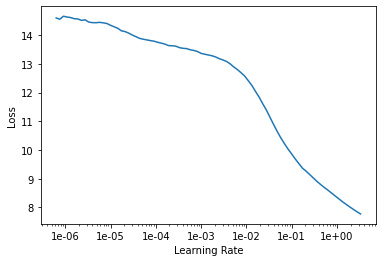

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, 1e-3, wd=0.2)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.023600,0.028428,0.172170,02:42
1,0.021700,0.019025,0.128951,02:44
2,0.016847,0.015119,0.118588,02:41
3,0.013793,0.014105,0.110311,02:53
4,0.012281,0.012175,0.104477,02:47


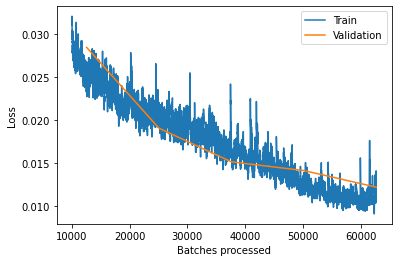

In [0]:
learn.save('1')
learn.recorder.plot_losses(skip_start=10000)

In [0]:
learn.load('1');
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.011611,0.014200,0.112159,02:45
1,0.011665,0.016701,0.110011,02:45
2,0.011347,0.016665,0.114238,02:45
3,0.010313,0.014945,0.112447,02:47
4,0.008561,0.012854,0.112779,02:44


In [0]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.012059,0.014142,0.122893,02:43
1,0.011295,0.018478,0.138108,02:42
2,0.011322,0.015752,0.125108,02:45
3,0.008597,0.032473,0.120108,02:44
4,0.008120,0.021601,0.120723,02:37


In [0]:
test_preds=learn.get_preds(DatasetType.Test)
test_df["Sales"]=np.exp(test_preds[0].data).numpy().T[0]
test_df[["Id","Sales"]]=test_df[["Id","Sales"]].astype("int")
test_df[["Id","Sales"]].to_csv("rossmann_submission.csv",index=False)

# pets revisited 
## * Data argmentation 
정규화 종류로 하나인 데이터확대. 데이터 확대는 정규화의 가장 잘 연구되지 않은 유형 중 하나이다.기본적으로 비용이 거의 들지 않기 때문이다. 데이터 증대를 수행하고 훈련 시간이 더 오래 걸리지 않고(적어도 어느 정도) 적합하지 않으면서 일반화를 개선할 수 있다. 

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *

In [0]:
bs = 64

In [0]:
path = untar_data(URLs.PETS)/'images'

In [0]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)

* 데이터 증가를 정말로 이해하기 위해서, 나는 모든 디폴트들을 조금씩 보완할 것이다. 여기에 아핀 변형이 일어날 확률,  lighting transfer이 일어날 확률을 나타내는 파라미터가 있어서 둘 다 1로 설정했다. 그래서 그들은 모두 변형될 것이고,  더 많은 회전, 더 많은 줌, 더 많은  lighting transfer, 그리고 더 뒤틀릴 것이다.

In [6]:
doc(get_transforms)

밝기의 다른 가치들을 보는 것은 두 가지를 봐야 한다. 첫번째는 이러한 변형의 수준들 중 어느 것을 위한 것인지에 대한 것이다. 그것은 여전히 그림이 무엇인지 명확하다. 왼쪽의 가장 큰 것은 상당히 불분명한 지점에 도달하는 것이고 오른쪽의 대부분은 약간 불분명한 상태가 될 수 있다. 두 번째로는 모델링하는 실제 데이터 세트나 특히 검증 세트로 사용할 데이터 세트를 살펴보고, 조명의 변화(이 경우)가 무엇인지 파악하려고 노력한다.

그래서 그들이 거의 모두 전문적으로 사진을 찍을 때, 나는 아마도 그들 모두가 중간에 있기를 원할 것이다. 하지만 그 사진들이 몇몇 예쁜 아마추어 사진작가에 의해 찍힌다면, 몇몇 사진작가들은 지나치게 노출되어 있고, 몇몇 사진작품은 노출되지 않은 사진작가들이 있을 것이다. 따라서 이 데이터 확대 값을 밝기에 맞게 선택해야 하며, 이 값을 사용하여 실제로 이미지를 모델링할 수 있는 데이터 유형도 나타내야 한다.

In [0]:
src = ImageList.from_folder(path).split_by_rand_pct(0.2, seed=2)

In [0]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

In [0]:
data = get_data(224, bs, 'zeros')   

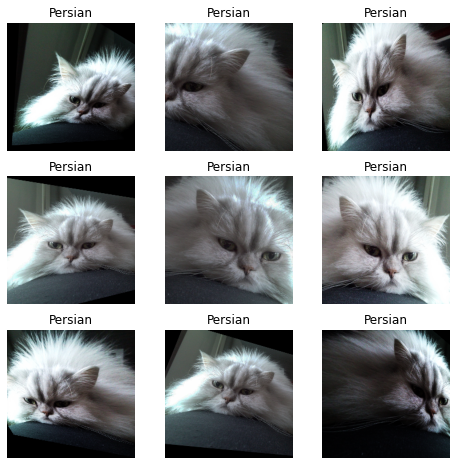

In [10]:
def _plot(i,j,ax):
    x,y = data.train_ds[3]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [0]:
data = get_data(224,bs)
      

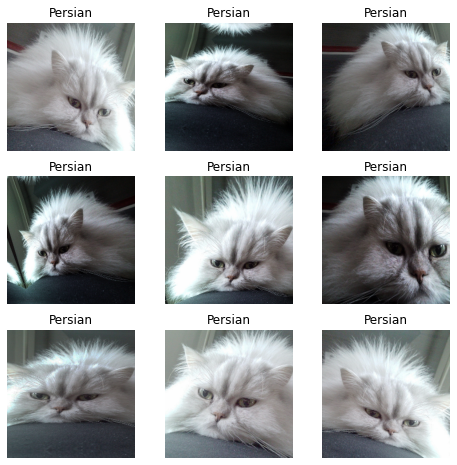

In [12]:
plot_multi(_plot, 3, 3, figsize=(8,8))

## Train model

In [0]:
gc.collect()
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True)

In [14]:
learn.fit_one_cycle(3, slice(1e-2), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,1.619496,0.356479,0.091340,01:43
1,0.989100,0.279665,0.080514,01:38
2,0.705903,0.234318,0.066982,01:37


In [15]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,0.580822,0.229830,0.060893,01:41
1,0.553448,0.226021,0.058863,01:42


In [0]:
data = get_data(352,bs)
learn.data = data

In [17]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))
learn.save('352')

epoch,train_loss,valid_loss,error_rate,time
0,0.501070,0.208962,0.043978,03:02
1,0.493480,0.203171,0.043302,03:05


# CNN에 관하여

* Heat map 에 관하여
 이 사진은 CNN이 이 사진이 무엇인지 결정하려고 할 때 이미지의 어떤 부분에 초점을 맞췄는지를 보여준다. 우리는 처음부터 이 Heat map를 만들 것이다.
순수한 텐서 산수를 사용한다.

* CNN에 대하여
 하지만 생각해보면, 배치 기준이 어떻게 작동하는지, DROP OUT이 어떻게 작동하는지, 또는 경합이 어떻게 작동하는지 아는 것은 모든 것이 어떻게 합쳐지고, 어떻게 해야 하는지, 그리고 어떻게 하면 더 잘 할 수 있는지를 아는 것만큼 중요하지 않다. 

 * 즉, 콘볼루션은 다음과 같은 두 가지 일이 일어나는 매트릭스 곱셈일 뿐이다.

일부 항목은 항상 0으로 설정됨
모든 것은 같은 색깔이고, 항상 같은 무게를 가지고 있다.
그래서 같은 무게의 여러 가지를 가지고 있을 때, 그것을 웨이트 타이라고 한다.

만약 우리가 입력을 한다면, 그것은 표준적인 종류의 빨강-녹색-파랑 사진일 것이다. 그러면 3x3 커널을 만들 수 있고, 그 커널을 다른 모든 픽셀에 전달할 수 있을 겁니다. 그런데 생각해보면 사실 2D입력이 더 이상 없다, 3D입력(즉, 3등급 텐서)이 있다. 그래서 우리는 빨강, 초록, 파랑 각각에 대해 같은 알맹이 값을 사용하지 않을 겁니다. 예를 들어, 우리가 녹색 개구리 탐지기를 만든다면, 파랑보다 녹색에서 더 많은 활성화를 원할 겁니다. 또는 우리가 실제로 녹색에서 파란색으로 이어지는 그라데이션(Gradient)을 찾을 수 있는 무언가를 찾으려 한다면, 각 채널에 대한 다른 커널들은 서로 다른 가치를 가질 필요가 있다. 따라서 우리는 3 x 3 x 3 커널을 만들어야 한다. 이것은 여전히 우리의 알맹이인데, 우리는 여전히 높이와 넓이에 걸쳐 아주 좋은 알맹이를 가지고 있다. 그런데 9가지 요소를 원소적으로 곱하기보다는 27개(3 X 3 X 3)의 원소-원소-구성을 해서 계속 1개 숫자로 합친다는 겁니다. 이 입방체를 이것과 그 뒤에 앉아 있을 그런 종류의 입방체(노란 입방체)를 지나갈 때. 우리가 콘볼루션의 그 부분을 할 때, 27개 모두를 요소-지혜적인 곱셈을 하고 그것들을 모두 합쳐서 만들기 때문에, 그것은 여전히 단 하나의 숫자를 만들어 낼 것이다.

우리는 전체 단일 유닛 패딩 입력에 걸쳐서 그것을 할 수 있다. 처음에는 5 대 5로 시작했으니까, 결국 5 대 5의 결과도 나올 겁니다. 하지만 지금 우리의 입력은 3개의 채널이었고 우리의 출력은 오직 하나의 채널이다. 우리는 단 한 개의 채널로도 그리 많은 것을 할 수 없을 것이다. 왜냐하면 우리가 지금 한 것은 최고의 가장자리를 찾은 것뿐이기 때문이다. 측면 가장자리를 어떻게 찾을 것인가? 그라데이션과 하얀색의 일정한 구역은? 음, 우리는 또 다른 커널을 만들어야 하고, 그 입력에 대해 콘볼루션된 것을 해야 할 것이고, 그러면 또 다른 5x5가 만들어질 겁니다. 그리고 우리는 이것을 다른 축으로 쌓아올릴 수 있고, 우리는 그것을 아주 많이 할 수 있고, 그러면 또 다른 3단계 텐서 출력을 얻을 수 있을 것이다.

실제로 그렇게 되는 것이다. 실제로 우리는 (이미지의 경우) 3에 의한 H by W의 입력으로 시작한다. 우리는 그것을 여러 개의 콘볼루션 알맹이들을 통해 전달하고, 우리가 얼마나 많은 것을 원하는지 선택할 수 있게 되고, 그것은 우리가 가지고 있던 수많은 알맹이들에 의해 폭에 의한 키의 산출물을 우리에게 되돌려주는데, 종종 그것은 첫 번째 층에서 16개 정도일 수도 있다. 16개의 채널이 있는데, 이 픽셀에 왼쪽 가장자리가 얼마나 있는지, 이 픽셀에 위쪽 가장자리가 얼마나 있는지, 그리고 RGB가 있는 9픽셀 세트에 파란색에서 빨간색 그라데이션이 얼마나 있었는지 같은 것들이죠.

그러면 그냥 똑같이 하면 돼. 또 다른 낟알 묶음을 가질 수 있고, 그러면 3등급의 다른 출력물이 만들어질 것이다. (어쨌든 폭에 따라 높이를 바꾸면 - 여전히 16이 될 수도 있다.) 우리가 정말로 하고 싶은 것은, 우리가 네트워크에 더 깊이 들어갈수록, 우리는 더 많은 채널을 갖고 싶어한다는 겁니다. 우리는 좀 더 풍부하고 풍부한 특징들을 찾을 수 있기를 원한다. 그래서 우리가 Zeiler와 Fergus 신문에서 보듯이, 4~5층에는 안구 탐지기와 모피 탐지기와 같은 것들이 있다. 그래서 당신은 정말 많은 채널이 필요하다.

기억력이 통제 불능 상태가 되는 것을 피하기 위해, 때때로 우리는 3x3의 모든 세트를 밟지 않고, 대신 한번에 두 세트를 건너뛰는 콘볼루션을 만든다. 우리는 (2, 2)를 중심으로 한 3x3으로 시작해서 (2,4), (2,6), (2,8), 등등으로 뛰어넘을 것이다. 그것은 2단계 경합이라고 불린다. 그게 하는 일은, 정확히 똑같아 보인다는 겁니다. 여전히 많은 알맹이들일 뿐이지만, 우리는 한번에 2개씩 뛰어 넘고 있는 겁니다. 우리는 모든 대체 입력 픽셀을 건너뛰고 있다. 그래서 그로부터의 출력은 W/2에 의한 H/2가 될 것이다. 우리가 그렇게 할 때, 우리는 일반적으로 두 배의 낟알을 만들어 낼 수 있다. 그래서 우리는 이제 각각의 지점들에서 32개의 활성화가 일어날 수 있다. 현대의 뇌신경망은 그렇게 보이는 경향이 있다.

## Convolution kernel

In [0]:
data = get_data(352,16)

Category great_pyrenees

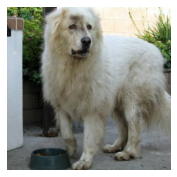

In [19]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True).load('352')
idx=0
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [20]:
k = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(1,3,3,3)/6
k

tensor([[[[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]]]])

콘볼루션 알맹이를 만든후  위과같이 오른쪽 가장자리에 양수를 가진 아래쪽 가장자리를 가지고 있고, 바로 그 안쪽에는 음수를 가지고 있다. 그래서 나는 이것이 나에게 오른쪽 아래 가장자리를 보여줘야 한다고 생각한다. 그래서 그게 만든 탠서다.

한 가지 복잡한 것은 3x3 낟알을 이 목적에 사용할 수 없다는 것이다. 왜냐하면 나는 2차원이 더 필요하기 때문이다. 첫 번째는 빨강녹색과 파랑색을 결합하는 방법을 말할 수 있는 세 번째 차원이 필요하다는 겁니다. 그래서 내가 하는 일은 확장이라고 말하는 거야. 이건 내 3x3이고, 시작에 또 다른 3개를 터뜨리는 거야. .Expand는 이것을 3번 복사해서 3x3x3 텐서를 만든다고 말한다. 복사한 척 하지만 기본적으로 같은 기억의 블록을 가리켜서, 일종의 기억 효율적 방법으로 복제하는 방식이다.

In [21]:
k.shape

torch.Size([1, 3, 3, 3])

In [22]:
t = data.valid_ds[0][0].data; t.shape

torch.Size([3, 352, 352])

In [23]:
t[None].shape

torch.Size([1, 3, 352, 352])

In [0]:
edge = F.conv2d(t[None], k)

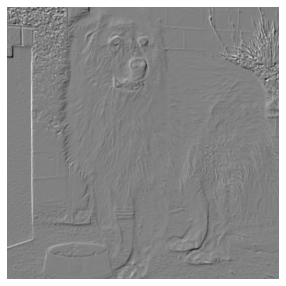

In [25]:
show_image(edge[0], figsize=(5,5));

In [26]:
data.c

37

In [27]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [28]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 176, 176]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 176, 176]       128        True      
______________________________________________________________________
ReLU                 [64, 176, 176]       0          False     
______________________________________________________________________
MaxPool2d            [64, 88, 88]         0          False     
______________________________________________________________________
Conv2d               [64, 88, 88]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 88, 88]         128        True      
______________________________________________________________________
ReLU                 [64, 88, 88]         0          False     
___________________________________________________

## Heatmap


* 히트맵 만들기
기본적으로 빨간색 녹색의 파란색을 가지고 있다. 그것은 여러 개의 회화 층을 거치며 더 많은 채널과 더 작고 더 작은 폭의 높이를 가진 활성화를 만든다. 11x11x512로 끝냈다. 건너뛴 층이 훨 많다.

지금은 data.c가 우리가 가지고 있는 CLASS의 수이기 때문에 37개의 CLASS가 있다. 그리고 우리는 여기서 마지막에 37가지 특징을 가지고 있다는 것을 알 수 있다. 결국 고양이와 개의 37개 품종에 대한 확률을 얻게 되는 겁니다. 길이 37의 벡터 입니다. 그것이 우리가 필요한 최종 산출물입니다. 왜냐하면 그것이 메인 쿤의 위치에 1을 가질 우리의 하나의 핫 인코딩 매트릭스와 암묵적으로 비교하기 때문입니다.

그래서 11에서 512까지 37까지 갈 필요가 있다.  이 11개 중 11개 면의 평균을 취한다는 것이다. 첫 얼굴의 평균을 취해서, 이 하나의 가치를 얻는 평균을 취하게 될 겁니다. 그럼 512개의 얼굴들 중 2위를 차지해서 그 뜻을 받아들이면 한 가지 더 가치가 있을 겁니다. 모든 얼굴에 512개의 긴 벡터를 부여할 겁니다.

그 후, 512 곱하기 37의 단일 행렬을 통해 37의 출력 벡터를 얻는 것이다. 우리가 각 얼굴의 평균을 취하는 이 단계를 평균 풀링이라고 부른다.

In [0]:
m = learn.model.eval();

In [0]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [0]:
from fastai.callbacks.hooks import *

In [0]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [0]:
hook_a,hook_g = hooked_backward()

In [34]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 11, 11])

In [35]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([11, 11])

In [0]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');

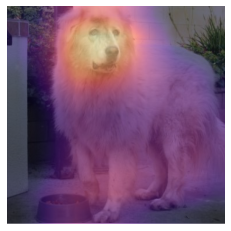

In [37]:
show_heatmap(avg_acts)

## Grad-CAM

In [38]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape,grad_chan.shape

(torch.Size([512, 11, 11]), torch.Size([512]))

In [0]:
mult = (acts*grad_chan[...,None,None]).mean(0)

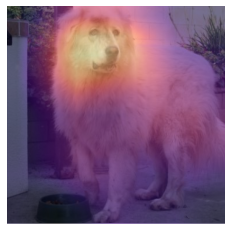

In [40]:
show_heatmap(mult)

In [0]:
fn = Path('/content/gdrive/My Drive/Colab Notebooks/00000028.jpg')


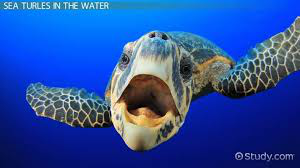

In [43]:
x = open_image(fn); x

In [0]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [0]:
hook_a,hook_g = hooked_backward()

In [0]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

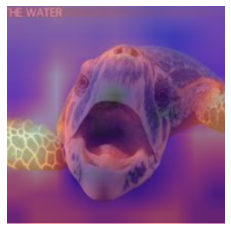

In [47]:
show_heatmap(mult)

In [48]:
data.classes[0]

'Abyssinian'

In [0]:
hook_a,hook_g = hooked_backward(0)

In [0]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

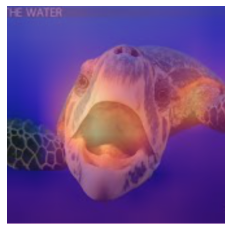

In [51]:
show_heatmap(mult)

1. 실행화면(1) : [링크 텍스트](https://drive.google.com/open?id=1GWxK9_DoZZYLPweGqXyvAaBcOPxvnj_9)
2. 실행화면(2) : [링크 텍스트](https://drive.google.com/open?id=1BYSnXYINTFICzm-Vf-Zcp55dacDc0YpZ)